In [1]:
import pandas as pd
import pyarrow.parquet as pq
import os
import numpy as np
from keras.layers import *
from keras.models import Model
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras import optimizers
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from keras.callbacks import *
from tqdm import tqdm

In [2]:
N_SPLITS = 5

In [3]:
def matthews_correlation(y_true, y_pred):
    '''Calculates the Matthews correlation coefficient measure for quality
    of binary classification problems.
    '''
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

In [4]:
# https://www.kaggle.com/suicaokhoailang/lstm-attention-baseline-0-652-lb

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [5]:
# just load train data
df_train = pd.read_csv(r"D:\DataSets\Partial Discharge Dataset-20230605T040721Z-003\Partial Discharge Dataset\metadata_train.csv")
# set index, it makes the data access much faster
df_train = df_train.set_index(['id_measurement', 'phase'])
df_train.head()

signal_id  target
id_measurement phase                   
0              0              0       0
               1              1       0
               2              2       0
1              0              3       1
               1              4       1

In [6]:
# in other notebook I have extracted the min and max values from the train data, the measurements
max_num = 127
min_num = -128

In [7]:
def min_max_transf(ts, min_data, max_data, range_needed=(-1,1)):
    if min_data < 0:
        ts_std = (ts + abs(min_data)) / (max_data + abs(min_data))
    else:
        ts_std = (ts - min_data) / (max_data - min_data)
    if range_needed[0] < 0:    
        return ts_std * (range_needed[1] + abs(range_needed[0])) + range_needed[0]
    else:
        return ts_std * (range_needed[1] - range_needed[0]) + range_needed[0]

In [8]:
def transform_ts(ts, n_dim=160, min_max=(-1,1)):
    ts_std = min_max_transf(ts, min_data=min_num, max_data=max_num)
    sample_size = 800000
    bucket_size = int(sample_size / n_dim)
    new_ts = []
    for i in range(0, sample_size, bucket_size):
        ts_range = ts_std[i:i + bucket_size]
        mean = ts_range.mean()
        std = ts_range.std()
        std_top = mean + std
        std_bot = mean - std
        percentil_calc = np.percentile(ts_range, [0, 1, 25, 50, 75, 99, 100])
        max_range = percentil_calc[-1] - percentil_calc[0]
        covar = std / mean
        asymmetry = mean - percentil_calc[4]
        new_ts.append(np.concatenate([np.asarray([mean, std_top, std_bot, max_range, covar, asymmetry]),percentil_calc]))
    return np.asarray(new_ts)

In [9]:
def prep_data(start, end):
    #praq_train = pq.read_pandas('../input/train.parquet').to_pandas()
    praq_train = pq.read_pandas(r"D:\DataSets\Partial Discharge Dataset-20230605T040721Z-003\Partial Discharge Dataset\train.parquet" ,columns=[str(i) for i in range(start, end)]).to_pandas()
    X = []
    y = []
    #for id_measurement in tqdm(df_train.index.levels[0].unique()):
    for id_measurement in tqdm(df_train.index.levels[0].unique()[int(start/3):int(end/3)]):
        X_signal = []
        for phase in [0,1,2]:
            signal_id, target = df_train.loc[id_measurement].loc[phase]
            if phase == 0:
                y.append(target)
            X_signal.append(transform_ts(praq_train[str(signal_id)]))
        X_signal = np.concatenate(X_signal, axis=1)
        X.append(X_signal)
    X = np.asarray(X)
    y = np.asarray(y)
    return X, y

In [10]:
X = []
y = []
def load_all():
    total_size = len(df_train)
    for ini, end in [(0, int(total_size/2)), (int(total_size/2), total_size)]:
        X_temp, y_temp = prep_data(ini, end)
        X.append(X_temp)
        y.append(y_temp)
load_all()
X = np.concatenate(X)
y = np.concatenate(y)

100%|██████████| 1452/1452 [05:33<00:00,  4.35it/s]


In [11]:
print(X.shape, y.shape)
np.save("X.npy",X)
np.save("y.npy",y)

(2904, 160, 39) (2904,)


In [12]:
def model_lstm(input_shape):
    inp = Input(shape=(input_shape[1], input_shape[2],))
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(inp)
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
    x = Attention(input_shape[1])(x)
    x = Dense(64, activation="relu")(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[matthews_correlation])
    
    return model

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Layer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import initializers, regularizers, constraints
from sklearn.model_selection import StratifiedKFold
import numpy as np

class Attention(Layer):
    def __init__(self, step_dim, **kwargs):
        self.supports_masking = True
        self.step_dim = step_dim
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1],),
                                 initializer='uniform', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[1],),
                                 initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x, mask=None):
        eij = K.squeeze(K.dot(x, K.expand_dims(self.W)), axis=-1) + self.b
        ai = K.exp(eij)
        if mask is not None:
            ai *= K.cast(mask, K.floatx())
        weights = ai / (K.sum(ai, axis=1, keepdims=True) + K.epsilon())
        weighted_input = x * K.expand_dims(weights)
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

def model_lstm(input_shape):
    inp = Input(shape=(input_shape[1], input_shape[2],))
    x = Bidirectional(LSTM(128, return_sequences=True))(inp)
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Attention(input_shape[1])(x)
    x = Dense(64, activation="relu")(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[matthews_correlation])
    
    return model

splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, y))
preds_val = []
y_val = []
for idx, (train_idx, val_idx) in enumerate(splits):
    K.clear_session()
    print("Beginning fold {}".format(idx+1))
    train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
    model = model_lstm(train_X.shape)
    ckpt = ModelCheckpoint('weights_{}.h5'.format(idx), save_best_only=True, save_weights_only=True, verbose=1, monitor='val_matthews_correlation', mode='max')
    model.fit(train_X, train_y, batch_size=128, epochs=50, validation_data=[val_X, val_y], callbacks=[ckpt])
    model.load_weights('weights_{}.h5'.format(idx))
    preds_val.append(model.predict(val_X, batch_size=512))
    y_val.append(val_y)

preds_val = np.concatenate(preds_val)[...,0]
y_val = np.concatenate(y_val)
preds_val.shape, y_val.shape


Beginning fold 1
Epoch 1/50
19/19 [==============================] - ETA: 0s - loss: 0.3581 - matthews_correlation: 0.0000e+00
Epoch 1: val_matthews_correlation improved from -inf to 0.00000, saving model to weights_0.h5
19/19 [==============================] - 38s 1s/step - loss: 0.3581 - matthews_correlation: 0.0000e+00 - val_loss: 0.2285 - val_matthews_correlation: 0.0000e+00
Epoch 2/50
19/19 [==============================] - ETA: 0s - loss: 0.2294 - matthews_correlation: 0.0000e+00
Epoch 2: val_matthews_correlation did not improve from 0.00000
19/19 [==============================] - 28s 2s/step - loss: 0.2294 - matthews_correlation: 0.0000e+00 - val_loss: 0.2204 - val_matthews_correlation: 0.0000e+00
Epoch 3/50
19/19 [==============================] - ETA: 0s - loss: 0.2239 - matthews_correlation: 0.0000e+00
Epoch 3: val_matthews_correlation did not improve from 0.00000
19/19 [==============================] - 27s 1s/step - loss: 0.2239 - matthews_correlation: 0.0000e+00 - val_lo

((2904,), (2904,))

In [14]:

"""import matplotlib.pyplot as plt

 Lists to store the training and validation metrics for each fold
train_matthews_correlation = []
val_matthews_correlation = []

for idx, (train_idx, val_idx) in enumerate(splits):
    K.clear_session()
    print("Beginning fold {}".format(idx+1))
    train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
    model = model_lstm(train_X.shape)
    ckpt = ModelCheckpoint('weights_{}.h5'.format(idx), save_best_only=True, save_weights_only=True, verbose=1, monitor='val_matthews_correlation', mode='max')
    history = model.fit(train_X, train_y, batch_size=128, epochs=50, validation_data=[val_X, val_y], callbacks=[ckpt])
    
    # Append training and validation Matthews correlation to the lists
    train_matthews_correlation.append(history.history['matthews_correlation'])
    val_matthews_correlation.append(history.history['val_matthews_correlation'])

# Plotting the trend for each fold
plt.figure()
for fold in range(len(train_matthews_correlation)):
    plt.plot(range(1, len(train_matthews_correlation[fold]) + 1), train_matthews_correlation[fold], label='Fold {} (Training)'.format(fold+1))
    plt.plot(range(1, len(val_matthews_correlation[fold]) + 1), val_matthews_correlation[fold], label='Fold {} (Validation)'.format(fold+1))

plt.title('Training and Validation Matthews Correlation')
plt.xlabel('Epoch')
plt.ylabel('Matthews Correlation')
plt.legend()
plt.show()"""


'import matplotlib.pyplot as plt\n\n Lists to store the training and validation metrics for each fold\ntrain_matthews_correlation = []\nval_matthews_correlation = []\n\nfor idx, (train_idx, val_idx) in enumerate(splits):\n    K.clear_session()\n    print("Beginning fold {}".format(idx+1))\n    train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]\n    model = model_lstm(train_X.shape)\n    ckpt = ModelCheckpoint(\'weights_{}.h5\'.format(idx), save_best_only=True, save_weights_only=True, verbose=1, monitor=\'val_matthews_correlation\', mode=\'max\')\n    history = model.fit(train_X, train_y, batch_size=128, epochs=50, validation_data=[val_X, val_y], callbacks=[ckpt])\n    \n    # Append training and validation Matthews correlation to the lists\n    train_matthews_correlation.append(history.history[\'matthews_correlation\'])\n    val_matthews_correlation.append(history.history[\'val_matthews_correlation\'])\n\n# Plotting the trend for each fold\nplt.figure()

Beginning fold 1
Epoch 1/50
19/19 [==============================] - ETA: 0s - loss: 0.3718 - matthews_correlation: 0.0021
Epoch 1: val_matthews_correlation improved from -inf to 0.00000, saving model to weights_0.h5
19/19 [==============================] - 31s 1s/step - loss: 0.3718 - matthews_correlation: 0.0021 - val_loss: 0.2390 - val_matthews_correlation: 0.0000e+00
Epoch 2/50
19/19 [==============================] - ETA: 0s - loss: 0.2406 - matthews_correlation: 0.0000e+00
Epoch 2: val_matthews_correlation did not improve from 0.00000
19/19 [==============================] - 25s 1s/step - loss: 0.2406 - matthews_correlation: 0.0000e+00 - val_loss: 0.2245 - val_matthews_correlation: 0.0000e+00
Epoch 3/50
19/19 [==============================] - ETA: 0s - loss: 0.2295 - matthews_correlation: 0.0000e+00
Epoch 3: val_matthews_correlation did not improve from 0.00000
19/19 [==============================] - 25s 1s/step - loss: 0.2295 - matthews_correlation: 0.0000e+00 - val_loss: 0.22

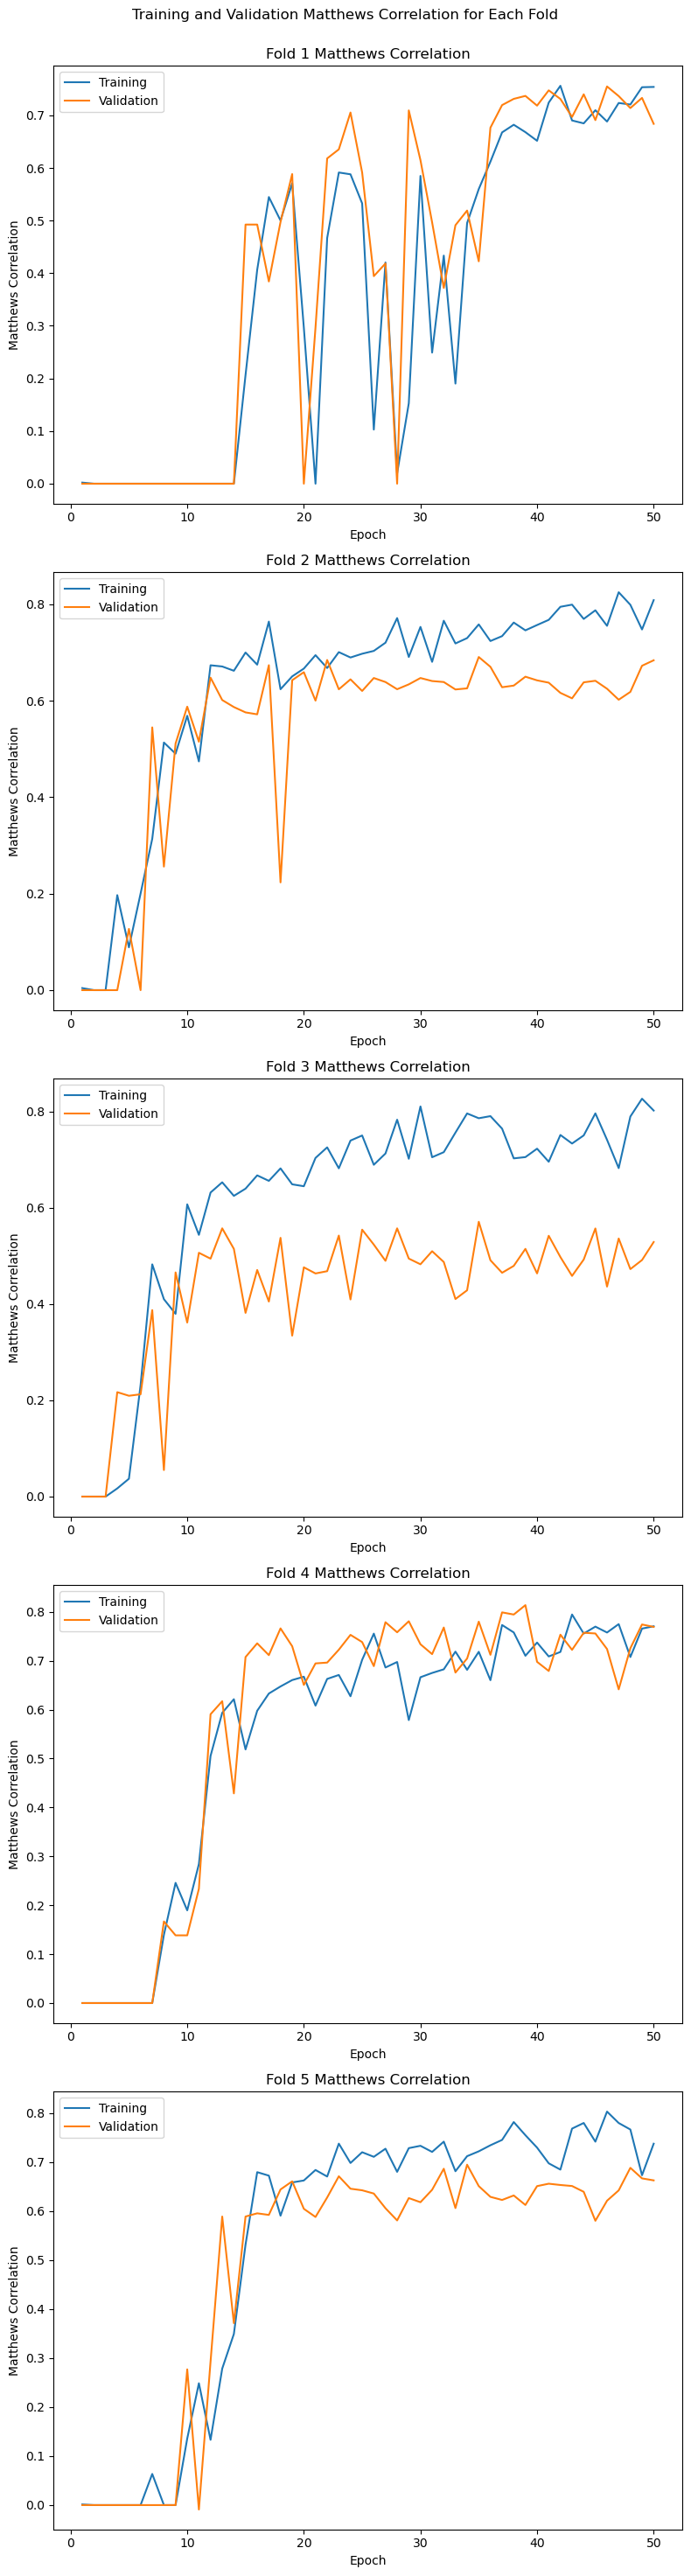

In [15]:
import matplotlib.pyplot as plt

# Lists to store the training and validation metrics for each fold
train_matthews_correlation = []
val_matthews_correlation = []

# Create subplots
fig, axs = plt.subplots(len(splits), 1, figsize=(8, 6 * len(splits)))

for idx, (train_idx, val_idx) in enumerate(splits):
    K.clear_session()
    print("Beginning fold {}".format(idx+1))
    train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
    model = model_lstm(train_X.shape)
    ckpt = ModelCheckpoint('weights_{}.h5'.format(idx), save_best_only=True, save_weights_only=True, verbose=1, monitor='val_matthews_correlation', mode='max')
    history = model.fit(train_X, train_y, batch_size=128, epochs=50, validation_data=[val_X, val_y], callbacks=[ckpt])
    
    # Append training and validation Matthews correlation to the lists
    train_matthews_correlation.append(history.history['matthews_correlation'])
    val_matthews_correlation.append(history.history['val_matthews_correlation'])
    
    # Plot training and validation accuracy in the subplot
    axs[idx].plot(range(1, len(train_matthews_correlation[idx]) + 1), train_matthews_correlation[idx], label='Training')
    axs[idx].plot(range(1, len(val_matthews_correlation[idx]) + 1), val_matthews_correlation[idx], label='Validation')
    axs[idx].set_title('Fold {} Matthews Correlation'.format(idx+1))
    axs[idx].set_xlabel('Epoch')
    axs[idx].set_ylabel('Matthews Correlation')
    axs[idx].legend()

# Set the main title for all subplots
fig.suptitle('Training and Validation Matthews Correlation for Each Fold')

# Adjust spacing between subplots
fig.tight_layout(rect=[0, 0, 1, 0.98])

# Display the plot
plt.show()


Loss v/s MCC

Beginning fold 1
Epoch 1/50
19/19 [==============================] - ETA: 0s - loss: 0.3791 - matthews_correlation: 0.0000e+00
Epoch 1: val_matthews_correlation improved from -inf to 0.00000, saving model to weights_0.h5
19/19 [==============================] - 37s 2s/step - loss: 0.3791 - matthews_correlation: 0.0000e+00 - val_loss: 0.2292 - val_matthews_correlation: 0.0000e+00
Epoch 2/50
19/19 [==============================] - ETA: 0s - loss: 0.2328 - matthews_correlation: 0.0000e+00
Epoch 2: val_matthews_correlation did not improve from 0.00000
19/19 [==============================] - 29s 2s/step - loss: 0.2328 - matthews_correlation: 0.0000e+00 - val_loss: 0.2295 - val_matthews_correlation: 0.0000e+00
Epoch 3/50
19/19 [==============================] - ETA: 0s - loss: 0.2299 - matthews_correlation: 0.0000e+00
Epoch 3: val_matthews_correlation did not improve from 0.00000
19/19 [==============================] - 28s 1s/step - loss: 0.2299 - matthews_correlation: 0.0000e+00 - val_lo

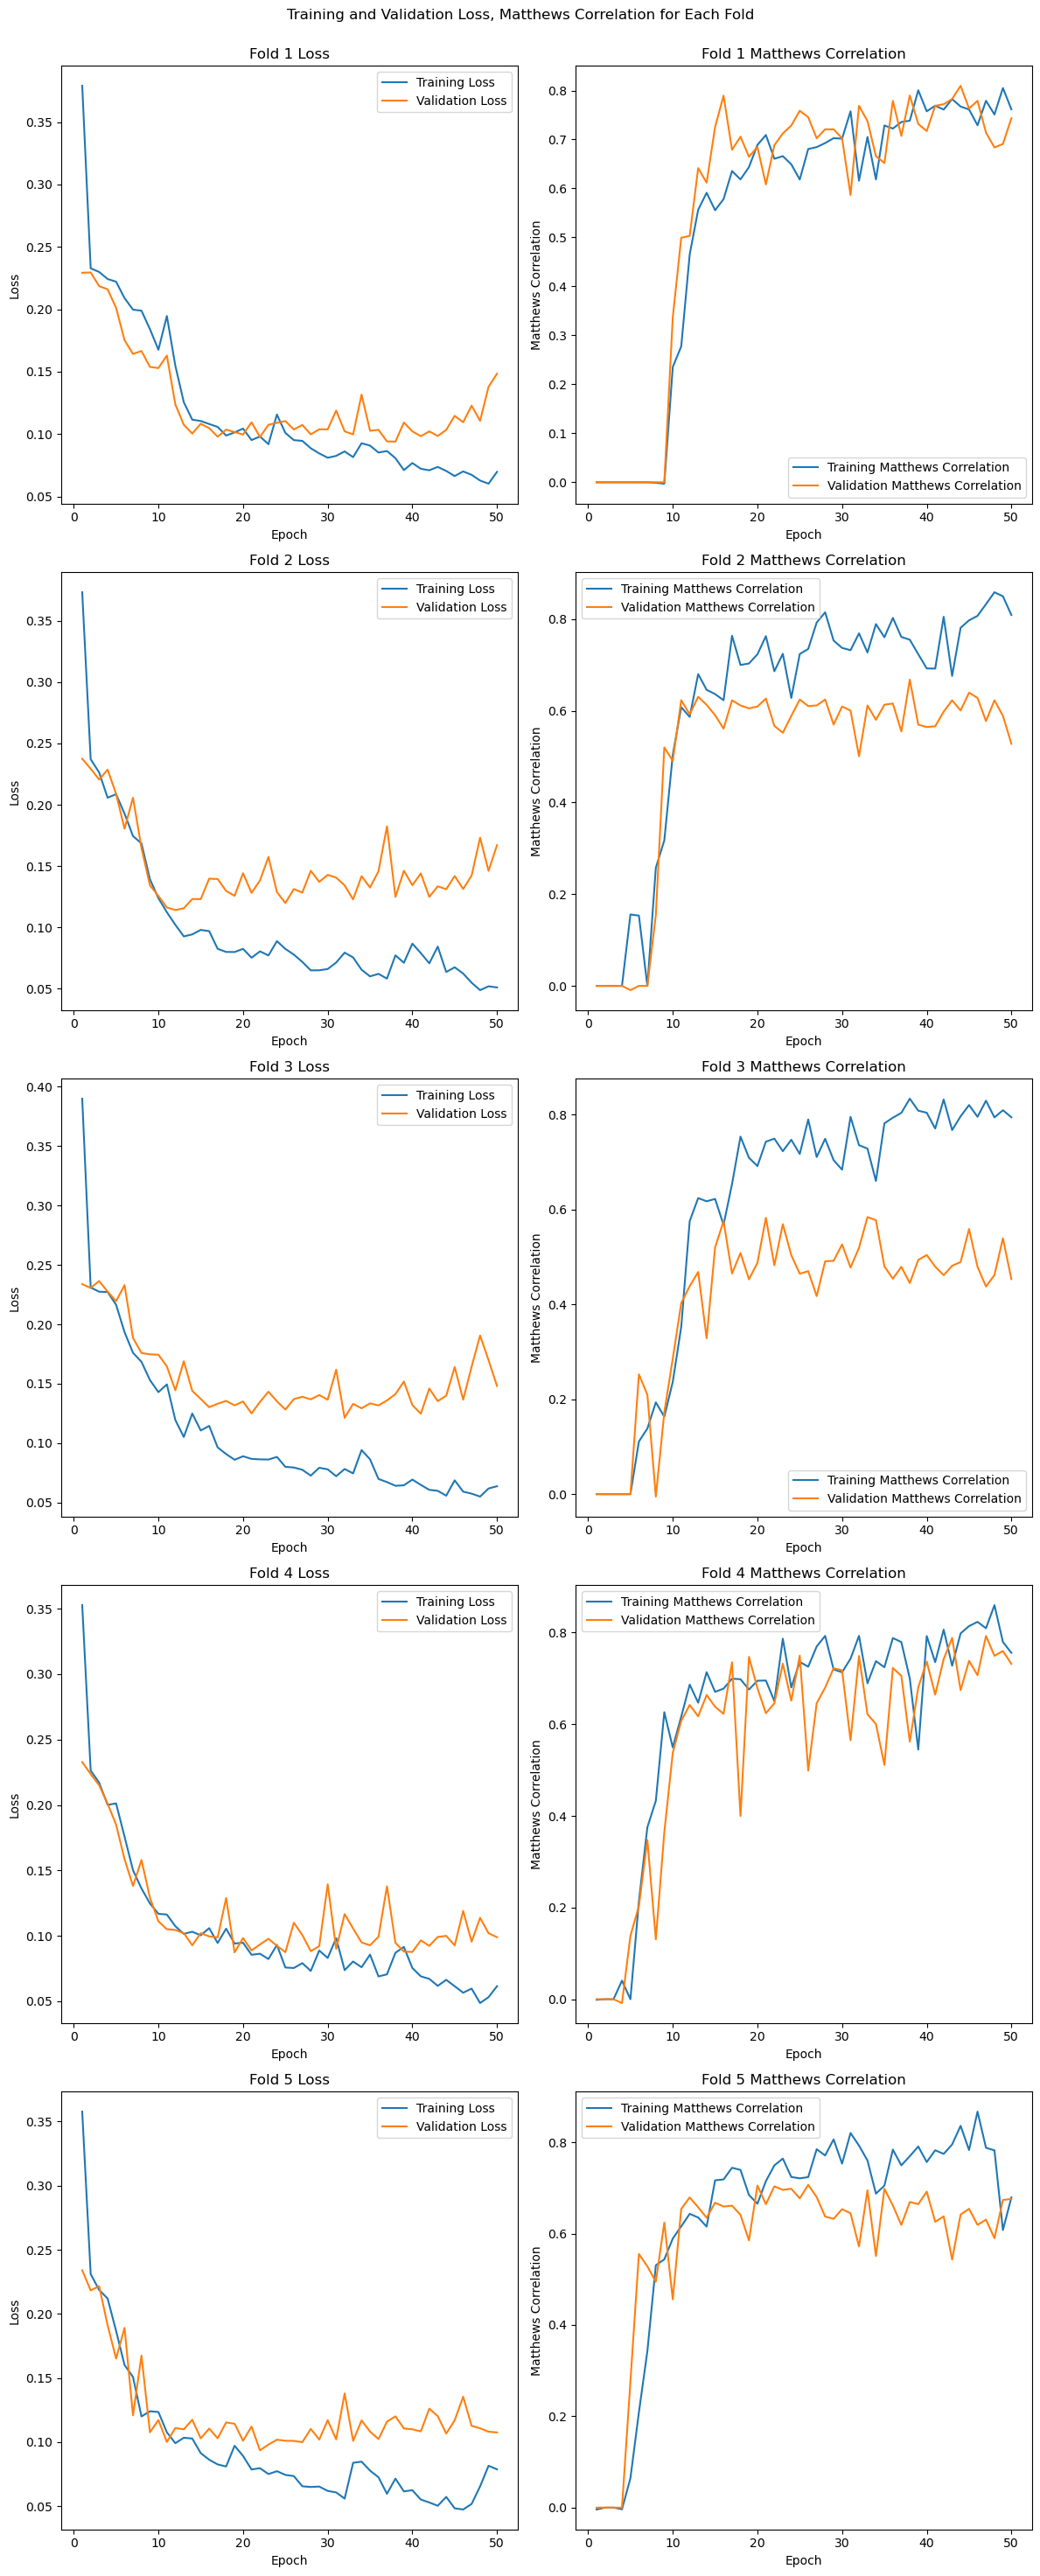

In [16]:
import matplotlib.pyplot as plt

# Lists to store the training and validation loss and Matthews correlation for each fold
train_loss = []
val_loss = []
train_matthews_correlation = []
val_matthews_correlation = []

# Create subplots
fig, axs = plt.subplots(len(splits), 2, figsize=(12, 6 * len(splits)))

for idx, (train_idx, val_idx) in enumerate(splits):
    K.clear_session()
    print("Beginning fold {}".format(idx+1))
    train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
    model = model_lstm(train_X.shape)
    ckpt = ModelCheckpoint('weights_{}.h5'.format(idx), save_best_only=True, save_weights_only=True, verbose=1, monitor='val_matthews_correlation', mode='max')
    history = model.fit(train_X, train_y, batch_size=128, epochs=50, validation_data=[val_X, val_y], callbacks=[ckpt])
    
    # Append training and validation loss and Matthews correlation to the lists
    train_loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])
    train_matthews_correlation.append(history.history['matthews_correlation'])
    val_matthews_correlation.append(history.history['val_matthews_correlation'])
    
    # Plot training and validation loss in the first subplot
    axs[idx, 0].plot(range(1, len(train_loss[idx]) + 1), train_loss[idx], label='Training Loss')
    axs[idx, 0].plot(range(1, len(val_loss[idx]) + 1), val_loss[idx], label='Validation Loss')
    axs[idx, 0].set_title('Fold {} Loss'.format(idx+1))
    axs[idx, 0].set_xlabel('Epoch')
    axs[idx, 0].set_ylabel('Loss')
    axs[idx, 0].legend()
    
    # Plot training and validation Matthews correlation in the second subplot
    axs[idx, 1].plot(range(1, len(train_matthews_correlation[idx]) + 1), train_matthews_correlation[idx], label='Training Matthews Correlation')
    axs[idx, 1].plot(range(1, len(val_matthews_correlation[idx]) + 1), val_matthews_correlation[idx], label='Validation Matthews Correlation')
    axs[idx, 1].set_title('Fold {} Matthews Correlation'.format(idx+1))
    axs[idx, 1].set_xlabel('Epoch')
    axs[idx, 1].set_ylabel('Matthews Correlation')
    axs[idx, 1].legend()

# Set the main title for all subplots
fig.suptitle('Training and Validation Loss, Matthews Correlation for Each Fold')

# Adjust spacing between subplots
fig.tight_layout(rect=[0, 0, 1, 0.98])

# Display the plot
plt.show()
